# Anomaly Detection Code Notebook

This code is based on the Anomaly code written by Nathanael Seay

1. This code first takes multiple files representing bearing noise and strings them together into one long waveform
1. Then builds a NN based on the LSTM-Autoencoder 
1. Predictions are made and the reconstruction loss is measured
1. Any loss greater than the set threshold is flagged as an anomaly
1. Anomalys are then traced back to their original files 

# load libraries 

In [1]:
# import libraries
import pandas as pd
# from Anomaly_Shaper import Shaper
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
# %matplotlib inline

from numpy.random import seed
import tensorflow as tf
# from tensorflow import set_random_seed

tf.keras.utils.set_random_seed(10)

# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)

# tf.logging.set_verbosity(tf.logging.ERROR)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

import glob

# load files
These file locations are on the AWS cloud


In [32]:
#path1 = "s3://sensor-data-nate/Sensor Data/Bearing_Sensor_Data_pt1"
#path2 = "s3://sensor-data-nate/Sensor Data/Bearing_Sensor_Data_pt2"


#filenames1 = glob.glob(path1 + "/*.39")
#filenames2 = glob.glob(path2 + "/*.39")
#filenames= filenames1+filenames2

import boto3
import os

# Initialize S3 client
s3 = boto3.client('s3')

def download_text_files(bucket_name, prefix1='', prefix2='', local_path='./'):
    """
    Download text files from an S3 bucket to a local directory.

    Parameters:
    - bucket_name: The name of the S3 bucket.
    - prefix1: (Optional) The first prefix (folder) within the S3 bucket.
    - prefix2: (Optional) The second prefix (folder) within the S3 bucket.
    - local_path: (Optional) The local directory where files will be downloaded.

    Returns:
    - List of downloaded file paths.
    """
    downloaded_files = []

    # List objects in the bucket for prefix1
    response1 = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix1)
    for obj in response1.get('Contents', []):
        key = obj['Key']
        if key.endswith('.39'):  # Only download text files
            local_file_path = os.path.join(local_path, key.split('/')[-1])  # Extract filename
            s3.download_file(bucket_name, key, local_file_path)
            downloaded_files.append(local_file_path)

    # List objects in the bucket for prefix2
    response2 = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix2)
    for obj in response2.get('Contents', []):
        key = obj['Key']
        if key.endswith('.39'):  # Only download text files
            local_file_path = os.path.join(local_path, key.split('/')[-1])  # Extract filename
            s3.download_file(bucket_name, key, local_file_path)
            downloaded_files.append(local_file_path)

    return downloaded_files

#if __name__ == "__main__":
    # Replace 'your-bucket-name' with the actual name of your S3 bucket
bucket_name = 'sensor-data-nate'

    # Specify the prefix (folder) within the bucket (optional)
prefix1 = 'Sensor Data/Bearing_Sensor_Data_pt1/'
prefix2 = 'Sensor Data/Bearing_Sensor_Data_pt2/'

    # Specify the local directory where files will be downloaded (optional)
local_path = './Sensor Data/Bearing_Sensor_Data_pt1/'

    # Download text files from the S3 bucket
downloaded_files = download_text_files(bucket_name, prefix1, prefix2, local_path)

print("Downloaded files:")
for file_path in downloaded_files:
    print(file_path)





Downloaded files:
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.10.52.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.11.02.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.11.12.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.11.22.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.11.32.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.11.42.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.11.52.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.12.02.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.12.12.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.12.22.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.12.32.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.12.42.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.12.52.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.13.02.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.13.12.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.13.22.39
./Sensor Data/Bearing_Sensor_Data_pt1/2004.02.12.13.32

# Defining Shaper() function
Function stings files into one long waveform


In [33]:
def Shaper(bearing, filenames):



  

    dfs1 = pd.DataFrame()
    dfs2 = pd.DataFrame()
    dfs3 = pd.DataFrame()
    dfs4 = pd.DataFrame()
    
    for filename in filenames:
        df=pd.read_csv(filename, sep='\t', header= None)
    
        #df1 = df.iloc[0]
        df1 = df.iloc[:, lambda df: [0]]
    
        dfs1= pd.concat([dfs1, df1], axis = 1)
        
        df2 = df.iloc[:, lambda df: [1]]
    
        dfs2= pd.concat([dfs2, df2], axis = 1)
        
        df3 = df.iloc[:, lambda df: [2]]
    
        dfs3= pd.concat([dfs3, df3], axis = 1)
        
        df4 = df.iloc[:, lambda df: [3]]
    
        dfs4= pd.concat([dfs4, df4], axis = 1)
    
    # melt1 = pd.melt(dfs1)
    # melt2 = pd.melt(dfs2)
    # melt3 = pd.melt(dfs3)
    # melt4 = pd.melt(dfs4)
    
    if (bearing==1):
        melt = pd.melt(dfs1)
        
    if (bearing==2):
        melt = pd.melt(dfs2)
        
    if (bearing==3):
        melt = pd.melt(dfs1)
            
    if (bearing==4):
        melt = pd.melt(dfs2)
        
    melt = melt["value"]
        
    return melt

# Calling Shaper() 
Giving function bearing and filenames 

In [34]:
bearing = 4
filenames = downloaded_files
wave_data = Shaper(bearing, filenames)

# Plotting waveform


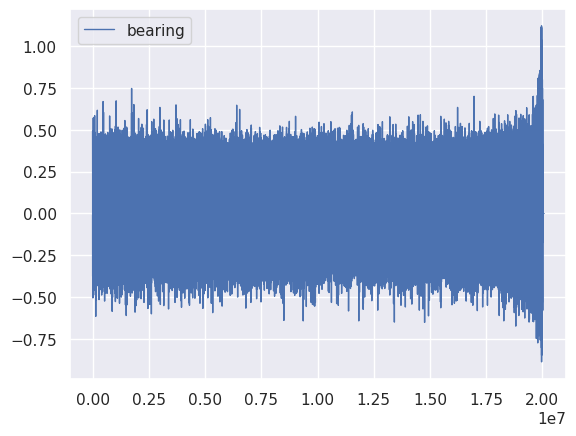

In [35]:
plt.plot(wave_data, label='bearing', linewidth=1)
plt.legend()
plt.show()

# Make training and test split

In [36]:
train_amount = int(len(wave_data) * 0.8)
test_amount = len(wave_data)

train = wave_data.iloc[:train_amount]
test = wave_data.iloc[train_amount:]

print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (16039936,)
Test dataset shape: (4009984,)


# Transform and scale training and split data

In [37]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train.values.reshape(-1, 1)) 
X_test = scaler.transform(test.values.reshape(-1, 1))  
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

# Make LSTM - Autoencoder Model

In [38]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], 1))  
    L1 = LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.001))(inputs)
    L2 = LSTM(16, activation='relu', return_sequences=True)(L1)
    L3 = LSTM(4, activation='relu', return_sequences=False)(L2)
    L4 = RepeatVector(X.shape[1])(L3)
    L5 = LSTM(4, activation='relu', return_sequences=True)(L4)
    L6 = LSTM(16, activation='relu', return_sequences=True)(L5)
    L7 = LSTM(64, activation='relu', return_sequences=True)(L6)
    output = TimeDistributed(Dense(1, activation='relu'))(L7)  
    model = Model(inputs=inputs, outputs=output)
    return model


model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

2024-02-19 23:48:24.518465: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 1, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 1, 16)             5184      
                                                                 
 lstm_2 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 4)              0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 1, 4)              144       
                                                             

# Defining epochs and batch size

In [39]:
nb_epochs = 15
batch_size = 10

# Training the model

In [ ]:
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

# Plot training and validation loss (on training set)

Epoch 1/15
 888986/1523794 [================>.............] - ETA: 1:35:17 - loss: 0.0538

In [ ]:
ig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Making Predictions based on training data

In [ ]:
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

# Adding reconstruction loss to 'scored' dataframe

In [ ]:
scored = pd.DataFrame()
#Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

# Determining the treshold value based on reconstuction loss distribution 

In [ ]:
min_value = scored['Loss_mae'].min()
max_value = scored['Loss_mae'].max()
range_ = max_value - min_value
range_of=  range_*.98

threshold = min_value+ range_of

# Making predictions based on test data set
This is the remaining data and the set were anomalies are most frequent

In [ ]:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)
X_pred.index = test.index

# Determining that anomalies based on reconstruction loss threshold

In [ ]:
scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[1])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

# Isolating anomalies and adding an index


In [ ]:
def traceback(scored, X_train):
    

  
    import pandas as pd
   
    
    sample_rate= 20480
    entry_number= len(scored['Loss_mae'])
    print(entry_number)
    increment= entry_number/sample_rate
   
    fileID = []
    j = 1
    for i in range(0, entry_number):
        #if i % increment:  # Check if the index is a multiple of the increment
        j=j+1
        fileID.append(j)
    scored['File_ID'] = fileID
    #print(fileID)
    ID_scored = scored.loc[scored['Anomaly'] == True]
    
    ID_scored = ID_scored.drop_duplicates(subset=['File_ID'])
   
    ID_scored['file_pointer']=(ID_scored['File_ID']+len(X_train))/sample_rate
    return ID_scored

ID_scored=traceback(scored, X_train)

# Tracing anomalies back to their files

In [ ]:
file_pointer=(ID_scored['file_pointer']).astype(int) 

file_pointer=file_pointer.drop_duplicates()

f = open("Anomaly_log.txt", "a")

for index in file_pointer:
    if 0 <= index < len(filenames):
        print(f"File at index {index}: {filenames[index]}")
        f.write(f"File at index {index}: {filenames[index]}")
    else:
        print(f"Index {index} is out of range.")

f.close()
